# Convolutional Neural Networks

### Imports

In [ ]:
#benötigte imports
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import Callback
import tensorflow as tf
from tensorflow.python.eager import context
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import os
import numpy as np
from keras.optimizers import Adam, SGD

### multithreading Einstellungen

In [ ]:
# parallelization Einstellungen
_ = tf.Variable([1])
context._context = None
context._create_context()
num_threads = os.cpu_count()
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
tf.config.threading.set_intra_op_parallelism_threads(num_threads)

### Daten Laden

In [ ]:
def load_mnist(kind='train', model_type ='convolutional'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(os.getcwd(),
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(os.getcwd(),
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)
    #wenn ein convolutional model, dann lese daten in form von 28x28 Matrix ein
    if model_type == 'convolutional':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                                offset=16).reshape(len(labels), 28, 28)#.reshape(len(labels), 784)
    #sonsts lese daten in 784 Vektor ein        
    elif model_type == 'fully_connected':
        with gzip.open(images_path, 'rb') as imgpath:
            images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
x_train_conv, y_train_conv = load_mnist(kind='train', model_type ='convolutional')
x_test_conv, y_test_conv = load_mnist(kind='t10k', model_type ='convolutional')
x_train_conv = np.expand_dims(x_train_conv, -1)
x_test_conv = np.expand_dims(x_test_conv, -1)

# Funktion zum Trainieren des Netzwerks, mit Rückgabe der Testgenauigkeit nach jedem Step

In [ ]:

# erstelle Klasse mit benutzerdefinierten Aktionen, die während des trainings ausgeführt werden sollen
class TrainMetricsCallback(Callback):
    def __init__(self, x_test=None, y_test=None):
        super(TrainMetricsCallback, self).__init__()
        # listen zum speichern der accuracy und losses auf dem Test und dem Trainingsdatenset nach jeder epoch
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        self.x_test = x_test
        self.y_test = y_test

    # Am ende der epoch füge die accuracy und loss werte zu den Listen hinzu
    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        
        if self.x_test is not None and self.y_test is not None:
            # Auswerten der modells für das Trainigsdatenset
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)
            self.test_losses.append(loss)
            self.test_accuracies.append(accuracy)
# Methode um nach jdem Trainingsschritt die accuracy und loss sowohl auf dem Testdatenset als auch
# auf den Trainingsdatenset als Liste zurückzugeben
def train_and_get_metrics(model, x_train, y_train, x_test=None, y_test=None, epochs=1, batch_size = 128):
    train_metrics_callback = TrainMetricsCallback(x_test, y_test)
    model.fit(x_train, y_train, epochs=epochs, callbacks=[train_metrics_callback],  batch_size=batch_size)
    
    # geben die accuracies und losses für die Test und Trainingsdaten zurück
    return train_metrics_callback.train_losses, train_metrics_callback.train_accuracies, \
           train_metrics_callback.test_losses, train_metrics_callback.test_accuracies, model

### Convolutional Modell erstellen

In [52]:
def createConvModel():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.BatchNormalization(input_shape=(28, 28,1)))
  model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(tf.keras.layers.BatchNormalization(input_shape=x_train_conv.shape[1:]))
  model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Activation('elu'))
  model.add(tf.keras.layers.Dense(10))
  model.add(tf.keras.layers.Activation('softmax'))
  return model
model_conv = createConvModel()

### Erstelltes Modell kompilieren und trainieren

In [53]:
no_epochs=17
batch_size=20
nr_train_data = 200   #kleiner als 60000
optimizer = Adam(learning_rate=1e-3)
model_conv.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])

train_losses_conv, train_accuracies_conv, test_losses_conv, test_accuracies_conv, model_conv = train_and_get_metrics(model_conv, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 3.8368 - sparse_categorical_accuracy: 0.3835  
Epoch 2/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 1.8927 - sparse_categorical_accuracy: 0.5867  
Epoch 3/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.6686 - sparse_categorical_accuracy: 0.7991  
Epoch 4/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.4124 - sparse_categorical_accuracy: 0.8630  
Epoch 5/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.2662 - sparse_categorical_accuracy: 0.8878  
Epoch 6/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.3742 - sparse_categorical_accuracy: 0.8764  
Epoch 7/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.1534 - sparse_categorical_accuracy: 0.9435  
Epoch 8/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.1045 - sparse_categorical_accuracy: 0.9595  
Epoch 9/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 0.1543 - sparse_categorical_accuracy: 0.9313  
Epoch 10/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - lo

In [54]:
# Konvertiert das 1D-Array in ein 2D-Array, das zum Plotten der Ziffer verwendet wird.
def to2DArray(vektor):
    matrix = np.zeros((28,28))
    for i in range(28):
        for j in range(28):
            matrix[i, j] = vektor[i*28 + j]
            
    return matrix

def predictAndPlotAndShowOutput(modell, testdaten, test_verifikationsdaten, label=False, convolutional = False):
    daten_verfügbar = range(len(testdaten))
    daten_zum_plotten = np.random.choice(daten_verfügbar, size = 6, replace=False)
    if label:
        fig, ax = plt.subplots(3, 4, figsize=(12, 12))
    else:
        fig, ax = plt.subplots(3, 4, figsize=(12, 9))
    for j in range(3):
        for i in range(2):
            vorhersage_verteilung = modell.predict(np.array([testdaten[daten_zum_plotten[j*2+i]]]))
            vorhersage = np.argmax(vorhersage_verteilung)
            confidence = np.max(vorhersage)
            if convolutional == False:
                ax[j, 2*i].imshow(to2DArray(testdaten[daten_zum_plotten[j*2+i]]), cmap='gray', interpolation='none')
            else:
                ax[j, 2*i].imshow(testdaten[daten_zum_plotten[j*2+i]], cmap='gray', interpolation='none')
    
            #+ ", confidence: " +str(round(confidence,3)))
            ax[j, 2*i].axes.get_xaxis().set_visible(False)
            ax[j, 2*i].axes.get_yaxis().set_visible(False)
            ax[j, 2*i+1].bar(np.arange(10), vorhersage_verteilung[0], color = 'navy')
            
            ax[j, 2*i+1].set_ylabel("Probability")
            ax[j, 2*i+1].set_ylim(0,1)
            ax[j, 2*i+1].set_title("Output")

            if label:
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xticklabels(label,rotation = 75)
                ax[j, 2*i].set_title("Prediction: "+label[vorhersage])
            else:
                ax[j, 2*i].set_title("Prediction: "+str(vorhersage))
                ax[j, 2*i+1].set_xticks(np.arange(10))
                ax[j, 2*i+1].set_xlabel("Digit")
    if label:
        plt.subplots_adjust(hspace=0.4, wspace=0.3)

  
    plt.tight_layout()
    plt.savefig("output.png", dpi=500)
    
    plt.subplots_adjust(hspace=0.4, wspace = 0.3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


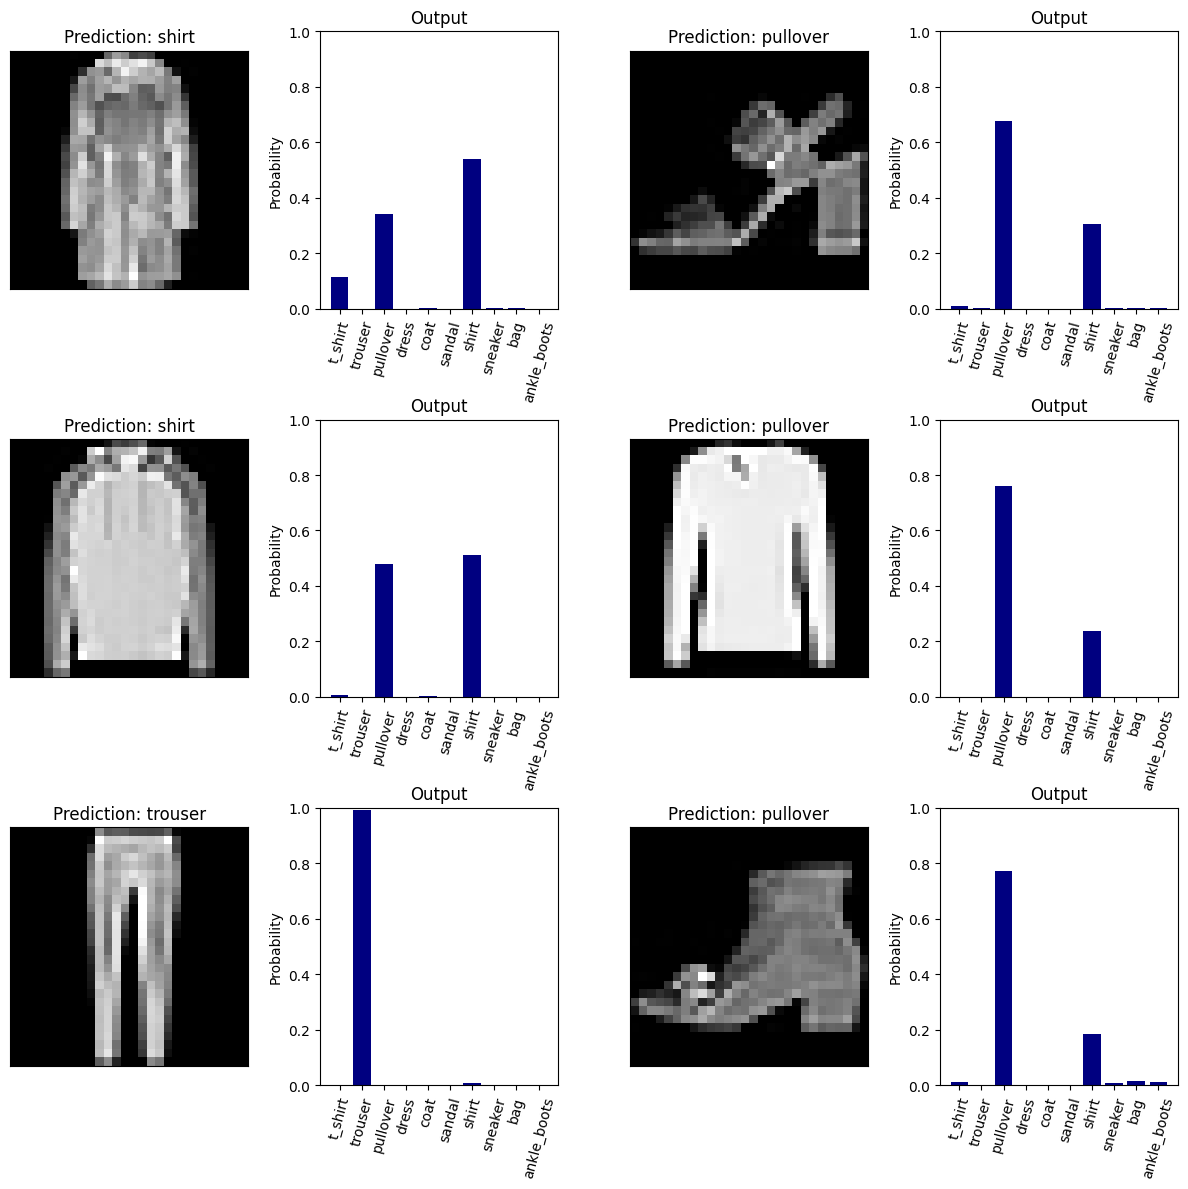

In [55]:
LABEL_NAMES = ['t_shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle_boots']
predictAndPlotAndShowOutput(model_conv, x_test_conv, y_test_conv, label=LABEL_NAMES, convolutional = True)

### Fully Connected Modell erstellen

In [56]:
def createFullyConnectedModel():
    model = tf.keras.models.Sequential()
    model.add(Dense(600, activation='relu', input_shape=(784,),name = "input_layer"))
    model.add(Dense(400, activation='relu',  name = "hidden_layer_1"))
    model.add(Dense(100, activation='relu',  name = "hidden_layer_2"))
    model.add(Dense(10, activation = 'softmax', name = "output_layer"))
    return model
model_fully_connected = createFullyConnectedModel()

/Users/moritzschroer/miniconda3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [57]:
x_train_full_connected, y_train_full_connected = load_mnist(kind='train', model_type ='fully_connected')
x_test_full_connected, y_test_full_connected = load_mnist(kind='t10k', model_type ='fully_connected')
x_train_full_connected = np.expand_dims(x_train_full_connected, -1)
x_test_full_connected = np.expand_dims(x_test_full_connected, -1)
optimizer = Adam(learning_rate=0.001)

### Training des Fully Connected Modells

In [58]:
nr_train_data = 200   #kleiner als 60000
optimizer = Adam(learning_rate=1e-3)
model_fully_connected.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
train_losses_fully_con, train_accuracies_fully_connected, test_losses_fully_connected, test_accuracies_fully_connected, model_fully_connected = train_and_get_metrics(model_fully_connected, x_train_full_connected[:nr_train_data], y_train_full_connected[:nr_train_data], x_test_full_connected, y_test_full_connected,  epochs=no_epochs,  batch_size=batch_size)


Epoch 1/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.1667 - loss: 113.1478
Epoch 2/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.4549 - loss: 27.7267
Epoch 3/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7866 - loss: 6.2858
Epoch 4/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6974 - loss: 9.6033
Epoch 5/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7533 - loss: 7.4956
Epoch 6/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7790 - loss: 7.8901
Epoch 7/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.7979 - loss: 8.0345
Epoch 8/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7999 - loss: 7.1036
Epoch 9/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8673 - loss: 4.3165
Epoch 10/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.8983 - loss: 2.3839
Epoch 11/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9002 - loss: 1.7348
Epoch 12/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - ac

### Vergleich Convolutional vs Fully connected   

### Feature detection des Convolutional Network

In [59]:
conv_layer_indices = [0]

# Lade ein Testbeispiel (z.B. x_test[0])
test_example = x_test_conv[0]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]
layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv.input, outputs=layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))
plt.imshow(x_test_conv[0], cmap='gray')
# Plotte die Zwischenergebnisse
for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[3]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.show()

ValueError: The layer sequential_4 has never been called and thus has no defined input.

### Vergleich Optimizer Adam vs SGD

In [62]:
model_conv_SGD = createConvModel()
no_epochs=17
batch_size=20
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_conv_SGD.compile(
      optimizer=optimizer,
      loss='sparse_categorical_crossentropy',
      metrics=['sparse_categorical_accuracy'])
train_losses_conv_SGD, train_accuracies_conv_SGD, test_losses_conv_SGD, test_accuracies_conv_SGD, model_conv_SGD = train_and_get_metrics(model_conv_SGD, x_train_conv[:nr_train_data], y_train_conv[:nr_train_data], x_test_conv, y_test_conv,  epochs=no_epochs,  batch_size=batch_size)

Epoch 1/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 2.2460 - sparse_categorical_accuracy: 0.2499  
Epoch 2/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 1.0522 - sparse_categorical_accuracy: 0.6645  
Epoch 3/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 0.7690 - sparse_categorical_accuracy: 0.8078  
Epoch 4/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - loss: 0.6022 - sparse_categorical_accuracy: 0.8815  
Epoch 5/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.5299 - sparse_categorical_accuracy: 0.8948  
Epoch 6/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.4354 - sparse_categorical_accuracy: 0.9212  
Epoch 7/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - loss: 0.3745 - sparse_categorical_accuracy: 0.9336  
Epoch 8/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3291 - sparse_categorical_accuracy: 0.9641  
Epoch 9/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.3077 - sparse_categorical_accuracy: 0.9626  
Epoch 10/17
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - lo

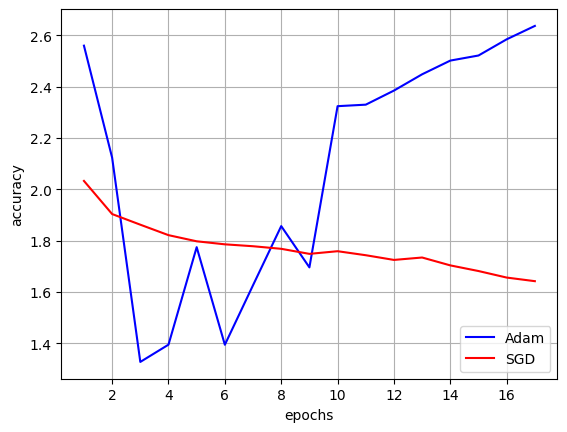

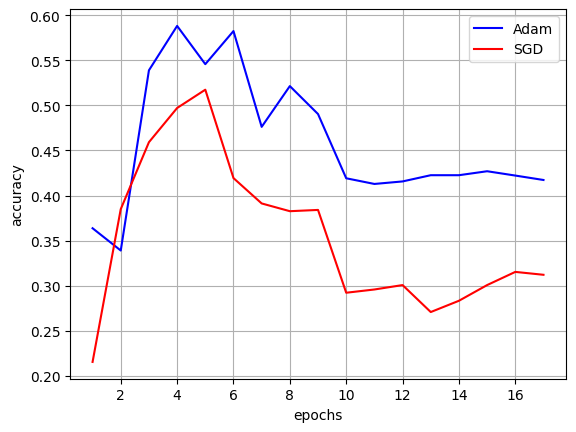

In [64]:
epochs = np.arange(1,no_epochs+1)
plt.plot(epochs,test_losses_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_losses_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

plt.plot(epochs,test_accuracies_conv, label = 'Adam', color = 'blue')
plt.plot(epochs,test_accuracies_conv_SGD, label = 'SGD', color = 'red')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.grid()
plt.legend()
plt.show()

In [73]:
# Beispiel-Eingabegröße festlegen (28x28x1 für MNIST)
input_shape = (28, 28, 1)

# Annahme: model_conv ist dein bestehendes Keras-Modell
# Stelle sicher, dass das Modell eine definierte Eingabeform hat
if not model_conv.built:
    model_conv.build((None, *input_shape))

# Wähle einige Convolutional Layers, um die Zwischenergebnisse zu extrahieren
conv_layer_indices = [0, 1, 2]

# Lade ein Testbeispiel (z.B. das erste Beispiel aus deinem Testdatensatz)
# x_test_conv sollte bereits normalisierte Bilder enthalten, z.B. (N, 28, 28, 1)
test_example = x_test_conv[0]

# Erstelle ein neues Modell, das die Zwischenergebnisse der ausgewählten Schichten ausgibt
conv_layers = [layer for layer in model_conv.layers if isinstance(layer, tf.keras.layers.Conv2D)]
conv_layer_outputs = [conv_layers[i].output for i in conv_layer_indices]
activation_model = tf.keras.models.Model(inputs=model_conv.input, outputs=conv_layer_outputs)

# Nutze das Testbeispiel, um die Zwischenergebnisse zu erhalten
activations = activation_model.predict(np.expand_dims(test_example, axis=0))

# Originalbild anzeigen
plt.imshow(test_example.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# Plotte die Zwischenergebnisse der ausgewählten Convolutional Layers
for i, activation in enumerate(activations):
    plt.figure(figsize=(10, 10))
    num_filters = activation.shape[-1]  # Anzahl der Filter für diesen Convolutional Layer
    num_plots = min(num_filters, 64)  # Höchstens 64 Plots
    for j in range(num_plots):
        plt.subplot(8, 8, j+1)
        plt.imshow(activation[0, :, :, j], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Activations of Layer {conv_layer_indices[i]}')
    plt.show()


ValueError: The layer sequential_4 has never been called and thus has no defined input.